In [1]:
import sys, time
import re, numpy as np, pandas as pd, seaborn as sns
pd.set_option('display.max_colwidth', None)
import matplotlib.pyplot as plt
%matplotlib inline


from random import randint
from tqdm import tqdm
tqdm.pandas()

import logging, warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import gensim 

import tensorflow as tf
import tensorflow.keras as keras 

In [2]:
df = pd.read_csv('df_cleaned.csv', index_col=0)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37960 entries, 689677 to 665299
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Best_Tags  37960 non-null  object
 1   Body_pc    37960 non-null  object
 2   Body_lm    37960 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


In [4]:
from ast import literal_eval

df["Best_Tags"] = df["Best_Tags"].progress_apply(lambda x: literal_eval(x))

100%|██████████| 37960/37960 [00:00<00:00, 113127.36it/s]


In [5]:
def split_and_count_tags(df, column, separator):
    list_words = []
    for word in df[column]: #.str.split(separator):
        list_words.extend(word)
    df_list_words = pd.DataFrame(list_words, columns=["Tag"])
    df_list_words = df_list_words.groupby("Tag")\
        .agg(tag_count=pd.NamedAgg(column="Tag", aggfunc="count"))
    df_list_words.sort_values("tag_count", ascending=False, inplace=True)
    return df_list_words

tags_list_df = split_and_count_tags(df=df, column='Best_Tags', separator=',')
nbr_tags = tags_list_df.shape[0]

print("Le jeu de données compte {} tags.".format(nbr_tags))
tags_list = tags_list_df.reset_index()['Tag'].values.tolist()

Le jeu de données compte 35 tags.


# Train / val / test split

In [6]:
def split_train_test_val(dataset,train_ratio = 0.9):
      
    # shuffle dataset
    dataset = dataset.sample(frac=1)

    # train set
    np.random.seed(seed=0)
    train_msk = np.random.rand(len(df)) < train_ratio
    train_df = dataset[train_msk]
    print('train_df shape = ', train_df.shape)

    # eval_test set
    np.random.seed(seed=42)
    eval_test_df  = dataset[~train_msk]
    eval_test_msk = np.random.rand((len(eval_test_df))) < 0.5 
    test_df = eval_test_df[eval_test_msk]
    eval_df = eval_test_df[~eval_test_msk]
    print('test_df shape = ', test_df.shape)
    print('eval_df shape = ', eval_df.shape)
    
    return train_df, test_df, eval_df

# Target Labels Binarizer
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

def binarize_target(mlb, train_df, test_df, eval_df):
    
    train_label = train_df['Best_Tags'].values.tolist()
    test_label  = test_df['Best_Tags'].values.tolist()
    eval_label  = eval_df['Best_Tags'].values.tolist()

    mlb.fit(train_label)

    train_label_bin = mlb.transform(train_label)
    test_label_bin = mlb.transform(test_label)
    eval_label_bin = mlb.transform(eval_label)


    print("Shape of y train: {}".format(train_label_bin.shape))
    print("Shape of y test: {}".format(test_label_bin.shape))
    print("Shape of y eval: {}".format(eval_label_bin.shape))
    
    return train_label_bin, test_label_bin, eval_label_bin, mlb

In [7]:
train_df, test_df, eval_df = split_train_test_val(df,train_ratio = 0.95)

train_df shape =  (36077, 3)
test_df shape =  (926, 3)
eval_df shape =  (957, 3)


In [8]:
train_label_bin, test_label_bin, eval_label_bin, mlb = binarize_target(mlb, train_df, test_df, eval_df)

Shape of y train: (36077, 35)
Shape of y test: (926, 35)
Shape of y eval: (957, 35)


In [9]:
def token_distribution(df,col):
    tk = [len(body) for body in df[col].apply(lambda x: x.split(" "))]
    maxSeq_len = max(tk)
    print(f"\n Le corps de texte le plus long contient {maxSeq_len} tokens. \n")

    plt.figure(figsize=(15,6))
    plt.hist(tk, bins=100)
    plt.title(f"Distribution du nombre de token dans la colonne {col}", fontsize=18)
    plt.xlabel('Nombre de tokens', fontsize=18)
    plt.xticks(fontsize=15)
    plt.ylabel('Nombre de lignes', fontsize=18 )
    plt.yticks(fontsize=15)
    plt.show()
    
    return maxSeq_len


 Le corps de texte le plus long contient 430 tokens. 



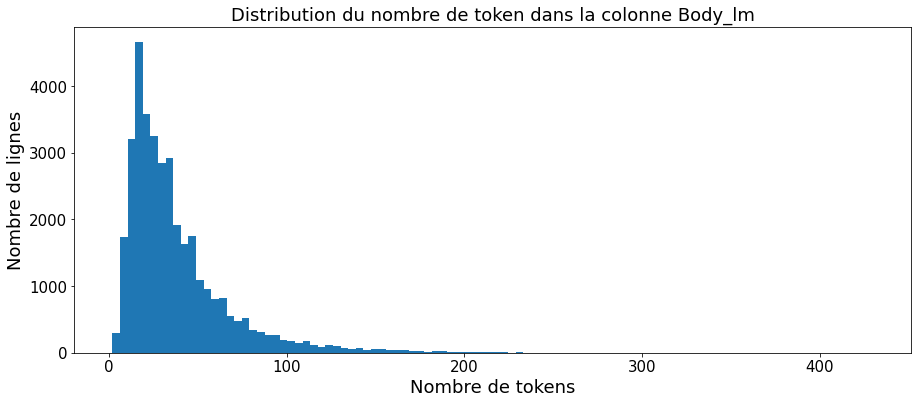

In [10]:
maxSeq_len = token_distribution(train_df, 'Body_lm')

# Suggestion non-supervisée avec LDA 

In [11]:
body = 'Body_lm'

initial pre cleaned maxSeq legth 
 63


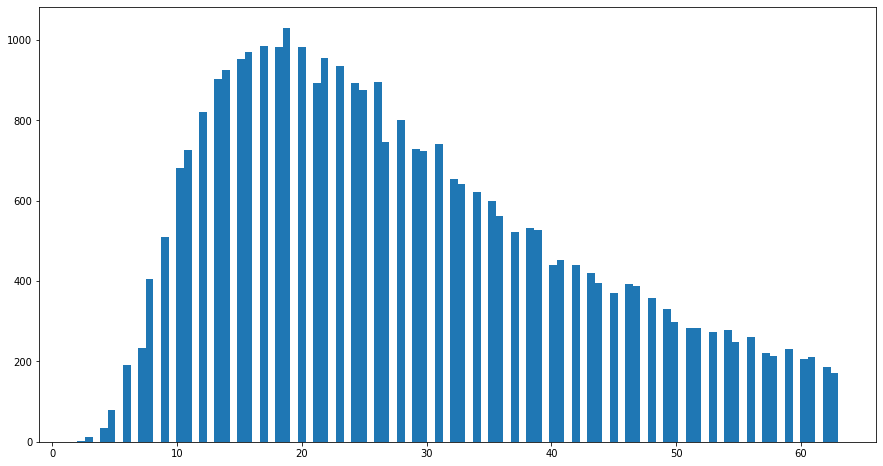

In [12]:
maxSeq_len = 64

data_long=[]
data_idx=[]
# data_ready=[]
for i,data in df[body].apply(lambda x: x.split(" ")).items():
    if (len(data) < maxSeq_len):
        data_idx.append(i)
#         data_ready.append(data)
    else:
        data_long.append(i)

df = df.loc[data_idx]

data_ready = df[body] 

body_len = [len(text) for text in data_ready.apply(lambda x: x.split(" "))]
print('initial pre cleaned maxSeq legth \n', max(body_len))

plt.figure(figsize=(15,8))
plt.hist(body_len, bins=100)
plt.show()

In [13]:
train_feats = train_df[body].apply(lambda x: x.split(" ")).copy()
print("Shape of x train: {}".format(train_feats.shape))

lda_train_label = train_label_bin.copy()
print("Shape of y train: {}".format(train_label_bin.shape))

Shape of x train: (36077,)
Shape of y train: (36077, 35)


In [14]:
# lda_test = [test_df, eval_df]
lda_test_df = pd.concat([test_df, eval_df]).copy()

lda_test_feats = lda_test_df[body].apply(lambda x: x.split(" ")) 
print("Shape of x test: {}".format(lda_test_feats.shape))

lda_test_label = np.concatenate((test_label_bin,eval_label_bin), axis=0)
print("Shape of y test: {}".format(lda_test_label.shape))

Shape of x test: (1883,)
Shape of y test: (1883, 35)


### Corpus & Disctionnaire 

In [15]:
import gensim.corpora as corpora

# Create Corpus 
data_ready = train_feats.copy()

# Create Dictionary
dictionnaire = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [dictionnaire.doc2bow(text) for text in data_ready]

### Recherche du meilleur nombre de topics via modélisation LDA  

In [16]:
from gensim.models import CoherenceModel

model_alpha = 'asymmetric'

# Iter LDA for best number of topics
coherence_test = []
for k in np.arange(1,50,5):
    print("Fitting LDA for K = {} topics".format(k))
    start_time = time.time()

    lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=dictionnaire,
                                                        num_topics=k,
                                                        random_state=0,
                                                        alpha=model_alpha,
                                                        passes=10,
                                                        iterations=150,
                                                        per_word_topics=False,
                                                        workers=4)

    coherence_model_lda = CoherenceModel(model=lda_model,
                                         texts=data_ready,
                                         dictionary=dictionnaire,
                                         coherence='c_v')
    
    coherence_lda = coherence_model_lda.get_coherence()
    end_time = time.time()
    coherence_test.append((k, coherence_lda,
                           (end_time - start_time)))

Fitting LDA for K = 1 topics
Fitting LDA for K = 6 topics
Fitting LDA for K = 11 topics
Fitting LDA for K = 16 topics
Fitting LDA for K = 21 topics
Fitting LDA for K = 26 topics
Fitting LDA for K = 31 topics
Fitting LDA for K = 36 topics
Fitting LDA for K = 41 topics
Fitting LDA for K = 46 topics


In [17]:
lda_model.alpha

array([0.06961765, 0.06067204, 0.05376362, 0.04826763, 0.04379108,
       0.04007441, 0.03693926, 0.03425908, 0.03194151, 0.02991763,
       0.02813494, 0.02655276, 0.02513905, 0.02386826, 0.02271978,
       0.02167674, 0.02072527, 0.01985381, 0.01905268, 0.0183137 ,
       0.0176299 , 0.01699533, 0.01640485, 0.01585403, 0.01533899,
       0.01485637, 0.01440318, 0.01397683, 0.01357499, 0.01319562,
       0.01283687, 0.01249711, 0.01217487, 0.01186883, 0.01157781,
       0.01130071, 0.01103656, 0.01078449, 0.01054366, 0.01031337,
       0.01009291, 0.00988168, 0.00967912, 0.00948469, 0.00929792,
       0.00911836], dtype=float32)

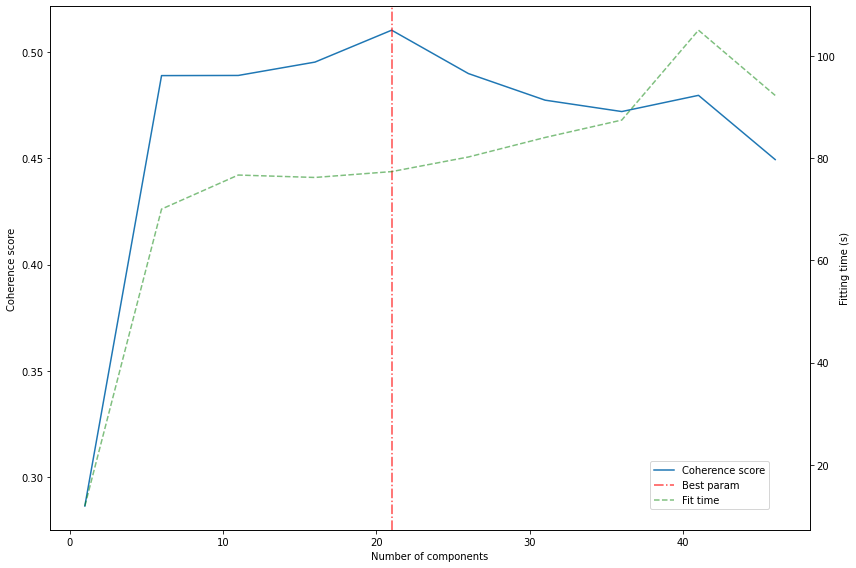

In [18]:
# Create dataframe of results
coherence_test = pd.DataFrame(coherence_test,
                              columns=["k","coherence","time"])

# Select best number of topics
best_nb_topics = coherence_test\
                    .loc[coherence_test.coherence.argmax(),"k"]

# Plot results
fig, ax1 = plt.subplots(figsize=(12,8))
x = coherence_test["k"]
y1 = coherence_test["coherence"]
y2 = coherence_test["time"]

ax1.plot(x, y1, label="Coherence score")
ax1.axvline(x=best_nb_topics, color='r', alpha=.7,
            linestyle='dashdot', label='Best param')
ax1.set_xlabel("Number of components")
ax1.set_ylabel("Coherence score")

ax2 = ax1.twinx()
ax2.plot(x, y2, label="Fit time",
         color='g', alpha=.5,
         linestyle='--')
ax2.set_ylabel("Fitting time (s)")

legend = fig.legend(loc='lower right', bbox_to_anchor=(.9, .1))

fig.tight_layout()
plt.show()

In [19]:
best_nb_topics

21

## best nb topics

In [20]:
num_topic = best_nb_topics

lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                    id2word=dictionnaire,
                                                    num_topics=num_topic,
                                                    random_state=100,
                                                    passes=10,
                                                    iterations=150,
                                                    alpha=model_alpha,
                                                    workers=4)

In [21]:
#Print Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, 
                                     texts=data_ready, 
                                     dictionary=dictionnaire, 
                                     coherence='c_v')

# coherence_model_lda = CoherenceModel(model=lda_model, 
#                                      corpus=corpus, 
#                                      dictionary=dictionnaire, 
#                                      coherence='u_mass')

coherence_lda = coherence_model_lda.get_coherence()

print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.48564120290788687


In [22]:
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models as gensimvis
from IPython.core.display import display, HTML
pyLDAvis.enable_notebook()

display(HTML("<style>.container { max-width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.output_area { max-width:100% !important; }</style>"))
display(HTML("<style>.input_area { max-width:100% !important; }</style>"))

gensimvis.prepare(lda_model, corpus, dictionnaire)

/home/ahea/.local/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
3     -0.082167 -0.077569       1        1  9.371141
1      0.043069 -0.090684       2        1  8.344717
5      0.110941  0.065607       3        1  6.837318
12    -0.077384  0.002086       4        1  6.062133
0     -0.037772  0.137214       5        1  5.753023
2      0.116781  0.124553       6        1  5.751166
14     0.172302 -0.009827       7        1  5.125504
16    -0.022878 -0.133493       8        1  4.766068
18     0.073317 -0.168513       9        1  4.463553
11     0.199260 -0.034453      10        1  4.355886
17    -0.099282  0.043911      11        1  4.286506
10    -0.094128  0.073825      12        1  4.264548
4      0.002059  0.115466      13        1  4.060642
15    -0.061590 -0.124460      14        1  4.055178
8     -0.184172 -0.018678      15        1  3.744825
13     0.153829  0.006975      16        1  3.713877
20    -0.202572 -0.005053      17        1  3.631326
7      0.093076 -0.010625      18        1  3.195739
9     -0.101401 -0.019517      19        1  2.949455
6     -0.011631  0.249600      20        1  2.636869
19     0.010342 -0.126366      21        1  2.630522, topic_info=          Term         Freq        Total Category  logprob  loglift
150     string  5376.000000  5376.000000  Default  30.0000  30.0000
91      object  6109.000000  6109.000000  Default  29.0000  29.0000
603       list  4880.000000  4880.000000  Default  28.0000  28.0000
770     python  5526.000000  5526.000000  Default  27.0000  27.0000
165   function  7151.000000  7151.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
662   generate   136.477556  2038.439573  Topic21  -5.5795   0.9342
295     result   140.808594  2985.252179  Topic21  -5.5482   0.5839
175  different   137.862358  3132.906630  Topic21  -5.5694   0.5145
256  something   142.206494  5285.658161  Topic21  -5.5383   0.0225
231       read   130.742625  3784.611996  Topic21  -5.6224   0.2725

[1535 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
12736     16  0.961841      \r\n
4073      21  0.970264         `
4074      21  0.983724        `#
12584     17  0.922677   abcdefg
3248       1  0.938347  abstract
...      ...       ...       ...
3521      17  0.986495      zone
2263       6  0.919851      zoom
2263      12  0.070758      zoom
2263      13  0.006433      zoom
5557      20  0.988330       zsh

[6734 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 6, 13, 1, 3, 15, 17, 19, 12, 18, 11, 5, 16, 9, 14, 21, 8, 10, 7, 20])

In [ ]:
def format_topics_sentences(ldamodel, corpus=corpus, texts=data_ready):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in tqdm(enumerate(ldamodel[corpus]), total=len(ldamodel[corpus])):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), 
                                                                  round(prop_topic,4), 
                                                                  topic_keywords]), ignore_index=True)
            else:
                break
                
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

#     # Add original text to the end of the output
#     contents = pd.Series(texts)
#     sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return (sent_topics_df)

###
# Format
df_dominant_topic = format_topics_sentences(lda_model)

# df_dominant_topic = df_topic_sents_keywords.reset_index()
# df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [25]:
df_dominant_topic.sample(5)

,Dominant_Topic,Perc_Contribution,Topic_Keywords
17526,0.0,0.9598,"function, server, follow, method, application, user, value, time, class, list"
2279,2.0,0.5018,"example, library, create, android, follow, application, class, object, view, page"
4040,3.0,0.3505,"class, function, call, method, python, java, add, create, example, image"
16174,4.0,0.6166,"app, string, column, table, value, create, something, list, method, well"
4850,1.0,0.9090,"object, array, value, java, net, method, user, time, class, add"


In [26]:
df_dominant_topic.groupby('Dominant_Topic')['Topic_Keywords'].unique()

Dominant_Topic
0.0        [function, server, follow, method, application, user, value, time, class, list]
1.0                      [object, array, value, java, net, method, user, time, class, add]
2.0    [example, library, create, android, follow, application, class, object, view, page]
3.0             [class, function, call, method, python, java, add, create, example, image]
4.0             [app, string, column, table, value, create, something, list, method, well]
5.0                       [change, set, create, git, add, problem, image, app, text, java]
Name: Topic_Keywords, dtype: object

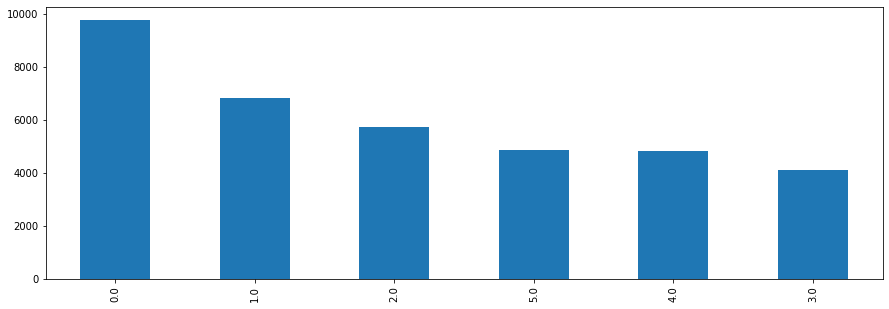

In [27]:
df_dominant_topic.Dominant_Topic.value_counts().plot(kind='bar', figsize=(15,5))
plt.show()

In [28]:
### Doc/Topic matrix

doc_all_topics = lda_model.get_document_topics(corpus)

mat_sparse = gensim.matutils.corpus2csc(doc_all_topics).T.toarray()

print(mat_sparse.shape)

mat_sparse

(36077, 6)


array([[0.13066128, 0.        , 0.50440347, 0.35129419, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.99112403],
       [0.95999712, 0.01198466, 0.        , 0.        , 0.        ,
        0.        ],
       ...,
       [0.97761762, 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.30237615, 0.        , 0.02694789, 0.        , 0.66713017,
        0.        ],
       [0.        , 0.        , 0.98082691, 0.        , 0.        ,
        0.        ]])

## Classement score_commentaire

In [29]:
def calcul_score_comm(phrase_test, mat_doc_topic, dictionnaire=dictionnaire, lda_model=lda_model):
    
    # phrase test dominant topic
    test_topic_dist = np.array([tup[1] for tup in lda_model.get_document_topics(
        bow=dictionnaire.doc2bow(phrase_test),
        minimum_probability=0.0)
                             ])
    test_dom_topic_idx = np.argsort(test_topic_dist)[-1]
#     print('test_dom_topic_idx :=', test_dom_topic_idx, 
#           ' & prob :=', test_topic_dist[test_dom_topic_idx])
    
    # distribution des mots pour le topic dominant
    mots_dist = []
    for word in phrase_test:
        if word in dictionnaire.values():
            all_dist  = lda_model.get_term_topics(word, minimum_probability=0.0)
            if len(all_dist)==lda_model.num_topics:
                term_dist = all_dist[test_dom_topic_idx][1]
                if term_dist > 1e-3:
                    mots_dist.append(term_dist)
                
    # boucle sur les commentaires du train set
    score_comm = []
    for pos, i in enumerate(range(mat_doc_topic.shape[0])):
        
        train_dom_topic_idx = np.argsort(mat_doc_topic[i])[-1]
        
        # uniquement si test & train ont le même topic dominant
        if int(train_dom_topic_idx) == int(test_dom_topic_idx):
            train_test_top = mat_doc_topic[i][train_dom_topic_idx]

            # calcul score
            calcul_score = 0
            for i in range(len(mots_dist)):
                calcul_score += np.log(mots_dist[i]*train_test_top)
            
            # Append resultat pour chaque commentaire
            score_comm.append((pos,calcul_score))
                        
    return score_comm, test_dom_topic_idx

In [30]:
df.columns

Index(['Best_Tags', 'Body_pc', 'Body_lm'], dtype='object')

In [31]:
from random import randint

In [32]:
test_df.shape[0]

926

In [33]:
# choix phrase test
iloc = randint(0,lda_test_df.shape[0])
print(iloc)

# print du Body original
lda_test_df[['Body_lm', 'Best_Tags']].iloc[iloc].to_frame().T

884


,Body_lm,Best_Tags
954480,automapper ignore rest tell automapper ignore property except map explicitly external dto class likely change outside avoid specify property ignore explicitly since add new property break functionality cause exception map object,[.net]


In [34]:
phr_test = lda_test_feats.iloc[iloc]
# print(phr_test)

score_phr_test = calcul_score_comm(phr_test,mat_sparse)

In [35]:
score_phr_test_sorted = sorted(score_phr_test[0], key=lambda x: (x[1]), reverse=True)
score_phr_test_sorted[:10]
# sorted(score_phr_test, key=lambda x: (x[1]), reverse=True)[:10]

[(8529, -57.36595856000765),
 (22289, -57.3680371816963),
 (17011, -57.37324400894053),
 (8993, -57.37877103568137),
 (20344, -57.379001669335956),
 (22154, -57.381990204002015),
 (11401, -57.382555897292846),
 (2432, -57.38260683522956),
 (331, -57.3857289271176),
 (10619, -57.38768035491696)]

In [36]:
## Resultat
top_pos = [tup[0] for tup in score_phr_test_sorted]
pos     = top_pos[0]
print(pos)

# print keyword
df_dominant_topic[['Topic_Keywords', 'Dominant_Topic']].iloc[pos].to_frame().T

8529


,Topic_Keywords,Dominant_Topic
8529,"object, array, value, java, net, method, user, time, class, add",1.0


In [37]:
# On recherche dans le train set
loc_train = lda_train_feats.iloc[top_pos[:3]].index

df_sugg = df[['Body_lm','Best_Tags']].loc[loc_train] #.to_frame().T
df_sugg

,Body_lm,Best_Tags
Id,,
263585,immutable object pattern c# course project develop pattern create immutable readonly object immutable object graph immutable object carry benefit thread safe therefore reuse across thread often pattern web application configuration setting object load cache memory cache object always immutable guarantee unexpectedly change course easily design immutable object follow example fine simple class complex class fancy concept pass value constructor setter property desirable construct new object read create immutable object setter well pattern object start fully mutable freeze single method call object frozen stay immutable forever turn mutable object mutable version object simply clone follow snippet boil pattern simple form ielement base interface immutable object must ultimately implement element class default implementation ielement interface let refactor sampleelement class implement immutable object pattern change property name property long object mark immutable call makereadonly method immutable call setter yield immutableelementexception final note full pattern complex snippet show contain support collection immutable object complete object graph immutable object graph full pattern enable turn entire object graph immutable call makereadonly method outermost object start create large object model pattern risk leaky object increase leaky object object fail call failifimmutable method change object test leak develop generic leak detector class unit test reflection test property method throw immutableelementexception immutable state word tdd grow pattern great benefit similar pattern yes resource document essentially potential improvement standard might already exist topic,[c#]
21554977,service always return dto return domain model design large scale application multi layer architecture base ddd mvc data layer implementation repository domain layer definition domain model interface repository service unit service layer implementation service far domain model mostly entitie across layer dto view model controller service return domain model controller create view model pass view read countless article mapping pass dto understand definitive answer sure return domain model service controller return domain model still never pass view since controller always create view specific view model case legit hand feel domain model leave business layer service layer sometimes service return datum object define domain either add new object domain map create poco object ugly since service return domain model effectively return dto strictly view model return domain model controller always dto communication service layer adjust domain model base service frankly since service consume domain strictly stick dto define service layer sometimes clear dtos service perform business logic create new object sometimes clear domain model membership service return anemic user much sense create dto domain model prefer consistency practice article domain dto viewmodel article similar problem answer article implement dto repository pattern similar deal ddd disclaimer intend design pattern exist fancy hand design pattern practice help design application whole help separation concern though particular pattern necessary least moment,[asp.net-mvc]
36968963,configure cor spring boot spring security application spring boot spring security cor support execute follow result test wrong credential instead standard wrong authentication spring security follow browser notification xml load access control allow origin header present request resource origin therefore allow access response status develop front end useful status server response handle situation something useful response body empty config wrong software bug chromium arch linux spring security spring config test curl everything perfect cor support simulate cor option request result wrong credential edit avoid misunderstanding spring boot blog post write cor support available upcoming 

In [38]:
sugg_tags = [tag for tag_list in df_sugg['Best_Tags'].values.tolist() for tag in tag_list]

sugg_tags

['c#', 'asp.net-mvc', 'javascript']

In [39]:
def list_unique(list1):
    # initialize a null list
    unique_list = []
 
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

sugg_unq = list_unique(sugg_tags)

if len(sugg_unq) < 5:
    print(sugg_unq)
else:
    print(sugg_unq[:5])

['c#', 'asp.net-mvc', 'javascript']


In [40]:
# tags réels (voir plus haut)
df[['Best_Tags']].loc[lda_test_df.iloc[iloc].name].tolist()

[['.net']]

In [41]:
# boucle sur les commentaires du test set
def y_test_tags(test_set, mat_sparse=mat_sparse):
    all_tags = []
    test_dom_topic = []
    
    for i in tqdm(range(len(test_set)), total=len(test_set)):
        test_sent   = test_set[i]
        scores_test, test_dom_topic_idx = calcul_score_comm(test_sent,mat_sparse)

        scores_sorted = sorted(scores_test, key=lambda x: (x[1]), reverse=True)[:3]

        ## Resultat
        top_pos = [tup[0] for tup in scores_sorted]
        pos     = top_pos

        # suggestions parmi le train set
        loc_train = lda_train_feats.iloc[top_pos].index
        suggestions_list = df['Best_Tags'].loc[loc_train].values.tolist()

        sugg_tags = [tag for tag_list in suggestions_list for tag in tag_list]
        sugg_unq = list_unique(sugg_tags)

        if len(sugg_unq) <= 3:
            final_sugg = sugg_unq
        else:
            final_sugg = sugg_unq[:3]
        
        all_tags.append(final_sugg)
        test_dom_topic.append(test_dom_topic_idx)

    return all_tags, test_dom_topic

In [42]:
pred_tags, pred_domTop = y_test_tags(lda_test_feats.tolist())

100%|██████████| 1883/1883 [14:03<00:00,  2.23it/s]


## Évaluation des suggestions 

In [43]:
pred_tags[:10]

[['mysql', 'ruby-on-rails', 'ruby'],
 ['sql-server', 'java', 'c#'],
 ['sql-server', 'java', 'c#'],
 ['java', 'python'],
 ['linux', 'python', 'sql'],
 ['c#', 'asp.net-mvc', 'javascript'],
 ['python', 'android', 'r'],
 ['c#', 'asp.net-mvc', 'javascript'],
 ['sql-server', 'java', 'c#'],
 ['linux', 'python', 'sql']]

In [44]:
lda_pred_label  = mlb.transform(pred_tags)
# lda_pred_label

In [45]:
# sugg_results = pd.DataFrame()
# sugg_results['real_tags'] = test_df['Best_Tags']

# sugg_results

In [138]:
from sklearn.metrics import classification_report

report = pd.DataFrame(classification_report(
    lda_test_label,
    lda_pred_label,
    output_dict=True,
    target_names=tags_list,
    zero_division=0
)).T

In [47]:
avg_index = ['samples avg', 'weighted avg','macro avg', 'micro avg' ]
avg_report = report.loc[avg_index]
avg_report

,precision,recall,f1-score,support
samples avg,0.091432,0.209152,0.123933,2490.0
weighted avg,0.072683,0.193976,0.081969,2490.0
macro avg,0.053759,0.114267,0.040595,2490.0
micro avg,0.088591,0.193976,0.121632,2490.0


In [48]:
clf_report = report[~report.index.isin(avg_report.index)]
clf_report.sort_values(by='support', ascending=False)

,precision,recall,f1-score,support
django,0.171854,0.585253,0.265690,217.0
php,0.136415,0.593137,0.221815,204.0
linux,0.103542,0.202128,0.136937,188.0
mysql,0.103064,0.411111,0.164811,180.0
ios,0.000000,0.000000,0.000000,138.0
c#,0.158416,0.384000,0.224299,125.0
python,0.000000,0.000000,0.000000,102.0
ruby,0.000000,0.000000,0.000000,100.0
sql,0.000000,0.000000,0.000000,88.0
iphone,0.000000,0.000000,0.000000,80.0


# Suggestion supervisée avec technique d'embedding

In [124]:
def plot_model_history(model):
            
    acc      = model.history.history[list(model.history.history.keys())[1]]
    val_acc  = model.history.history[list(model.history.history.keys())[3]]
    loss     = model.history.history[list(model.history.history.keys())[0]]
    val_loss = model.history.history[list(model.history.history.keys())[2]]
    epochs   = model.history.epoch

    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()  

## Word2vec

In [49]:
body = 'Body_lm'

In [50]:
w2v_train_feats = train_df[body].apply(lambda x: x.split(" ")).copy()
print("Shape of x train: {}".format(w2v_train_feats.shape))

w2v_train_label = train_label_bin.copy()
print("Shape of y train: {}".format(w2v_train_label.shape))

Shape of x train: (36077,)
Shape of y train: (36077, 35)


In [51]:
w2v_test_feats = test_df[body].apply(lambda x: x.split(" ")) 
print("Shape of x test: {}".format(w2v_test_feats.shape))

w2v_test_label = test_label_bin.copy()
print("Shape of y test: {}".format(w2v_test_label.shape))

Shape of x test: (926,)
Shape of y test: (926, 35)


In [52]:
w2v_eval_feats = eval_df[body].apply(lambda x: x.split(" ")) 
print("Shape of x eval: {}".format(w2v_eval_feats.shape))

w2v_eval_label = eval_label_bin.copy()
print("Shape of y eval: {}".format(w2v_eval_label.shape))

Shape of x eval: (957,)
Shape of y eval: (957, 35)


In [53]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(w2v_train_feats) 

num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)


train_sequences = tokenizer.texts_to_sequences(w2v_train_feats) 
train_padded = pad_sequences(
    train_sequences, 
    maxlen=maxSeq_len, 
    truncating="post", 
    padding="post"
)

test_sequences = tokenizer.texts_to_sequences(w2v_test_feats) 
test_padded = pad_sequences(
    test_sequences, 
    maxlen=maxSeq_len, 
    truncating="post", 
    padding="post"
)

eval_sequences = tokenizer.texts_to_sequences(w2v_eval_feats) 
eval_padded = pad_sequences(
    eval_sequences, 
    maxlen=maxSeq_len, 
    truncating="post", 
    padding="post"
)

Number of unique words: 33110


## Création du modèle Word2Vec

In [54]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=10

In [55]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, 
                                   window=w2v_window,
                                   vector_size=w2v_size,
                                   seed=42,
                                   workers=8)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(w2v_train_feats)
w2v_model.train(w2v_train_feats, 
                total_examples=w2v_model.corpus_count, 
                epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 33109
Word2Vec trained


## Création de la matrice d'embedding

In [56]:
print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  0.9999
Embedding matrix: (33110, 300)


## Création du modèle d'embedding

In [59]:
embedding_layer = keras.layers.Embedding(len(word_index) + 1,
                            w2v_size,
                            weights=[embedding_matrix],
                            input_length=maxSeq_len,
                            trainable=False)

In [87]:
word_input         = keras.layers.Input(shape=(maxSeq_len,), dtype='float64')  
word_embedding     = keras.layers.Embedding(input_dim    = vocab_size,
                                            output_dim   = w2v_size,
                                            weights      = [embedding_matrix],
                                            input_length = maxSeq_len)(word_input)

x                  = keras.layers.GlobalAveragePooling1D()(word_embedding)  
x                  = keras.layers.Dropout(0.1)(x) # 0.3
word_output        = keras.layers.Dense(nbr_tags, activation='softmax')(x)
w2v_embed_model    = keras.models.Model([word_input],word_output)

w2v_embed_model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.BinaryCrossentropy(), 
              metrics=[tf.keras.metrics.CategoricalAccuracy('accuracy')])

w2v_embed_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 430)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 430, 300)          9933000   
                                                                 
 global_average_pooling1d_2   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 300)               0         
                                                                 
 dense_4 (Dense)             (None, 35)                10535     
                                                                 
Total params: 9,943,535
Trainable params: 9,943,535
Non-trainable params: 0
_________________________________________________

In [61]:
# from keras.callbacks import ModelCheckpoint
# #create callback
# filepath = 'best_w2v.hdf5'

# checkpoint = ModelCheckpoint(filepath=filepath, 
#                              monitor='val_loss',
#                              verbose=1, 
#                              save_best_only=True,
#                              mode='min')
# callbacks = [checkpoint]

In [88]:
w2v_history = w2v_embed_model.fit(
    train_padded,
    train_label_bin,
    epochs=5,
    batch_size=128,
    validation_data=[eval_padded, 
                     eval_label_bin],
    verbose=1,
#     callbacks=callbacks
)

Epoch 1/5
282/282 [==============================] - 44s 153ms/step - loss: 0.2364 - accuracy: 0.1068 - val_loss: 0.1505 - val_accuracy: 0.1233
Epoch 2/5
282/282 [==============================] - 42s 149ms/step - loss: 0.1482 - accuracy: 0.1688 - val_loss: 0.1475 - val_accuracy: 0.1933
Epoch 3/5
282/282 [==============================] - 42s 149ms/step - loss: 0.1446 - accuracy: 0.2194 - val_loss: 0.1434 - val_accuracy: 0.2456
Epoch 4/5
282/282 [==============================] - 43s 153ms/step - loss: 0.1400 - accuracy: 0.2629 - val_loss: 0.1382 - val_accuracy: 0.2738
Epoch 5/5
282/282 [==============================] - 43s 153ms/step - loss: 0.1341 - accuracy: 0.3000 - val_loss: 0.1319 - val_accuracy: 0.3365


# Evaluation du model

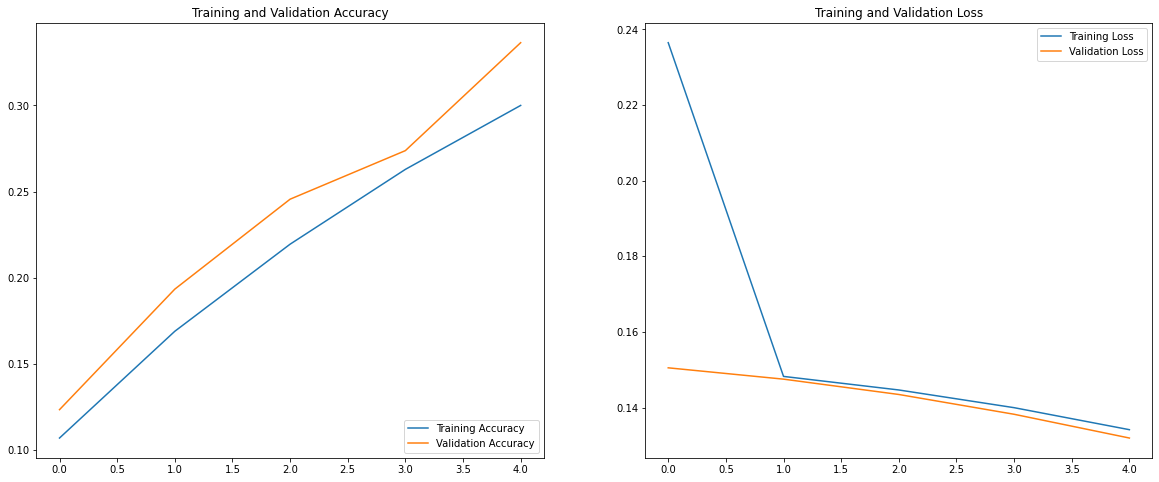

In [123]:
plot_model_history(w2v_embed_model)

In [65]:
w2v_embed_model.evaluate(test_padded, w2v_test_label)

29/29 [==============================] - 0s 4ms/step - loss: 0.0678 - categorical_accuracy: 0.6706


[0.06777170300483704, 0.6706263422966003]

In [140]:
w2v_pred_proba = w2v_embed_model.predict(test_padded)

29/29 [==============================] - 0s 5ms/step


In [146]:
tresh = 0.3
w2v_pred_proba[w2v_pred_proba >= tresh] = 1
w2v_pred_proba[w2v_pred_proba < tresh] = 0

# Inverse transform
w2v_pred_inversed = mlb.inverse_transform(w2v_pred_proba)
w2v_test_inversed = mlb.inverse_transform(w2v_test_label)

pos = randint(0,test_label_bin.shape[0])
display(test_df.iloc[pos])
print()
print('predicted label :=', w2v_pred_inversed[pos])
print('actual label :=',w2v_test_inversed[pos])

Best_Tags                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  [php, arrays]
Body_pc      how to sort a date array in php. i have an array in this format i want to sort them out in the ascending order of the dates based on the month day and year . what s the best way to do that? originally the emails are being fetched in the mysql date format so 


predicted label := ()
actual label := ('arrays', 'php')


# Transfer Learning

In [80]:
body = 'Body_pc'

In [81]:
tl_train_feats = train_df[body] #.apply(lambda x: x.split(" ")).copy()
print("Shape of x train: {}".format(tl_train_feats.shape))

tl_train_label = train_label_bin.copy()
print("Shape of y train: {}".format(tl_train_label.shape))

Shape of x train: (36077,)
Shape of y train: (36077, 35)


In [82]:
tl_test_feats = test_df[body] #.apply(lambda x: x.split(" ")) 
print("Shape of x test: {}".format(tl_test_feats.shape))

tl_test_label = test_label_bin.copy()
print("Shape of y test: {}".format(tl_test_label.shape))

Shape of x test: (926,)
Shape of y test: (926, 35)


In [83]:
tl_eval_feats = eval_df[body] #.apply(lambda x: x.split(" ")) 
print("Shape of x eval: {}".format(tl_eval_feats.shape))

tl_eval_label = eval_label_bin.copy()
print("Shape of y eval: {}".format(tl_eval_label.shape))

Shape of x eval: (957,)
Shape of y eval: (957, 35)


# BERT

In [75]:
import tensorflow_hub as hub
import tensorflow_text as text

bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", trainable=True)

In [76]:
# Bert input
text_input        = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessed_text = bert_preprocess(text_input)
encoded_text      = bert_encoder(preprocessed_text)
sequence_output   = encoded_text['sequence_output']

# Neural network layers
b  = tf.keras.layers.GlobalAveragePooling1D()(sequence_output)
b = tf.keras.layers.Dense(128, activation='relu')(b)
b = tf.keras.layers.Dropout(0.3)(b)
b_out = tf.keras.layers.Dense(nbr_tags, activation='softmax')(b)

bert_embed_model = tf.keras.Model(inputs=[text_input], outputs = b_out)

bert_embed_model.compile(optimizer=tf.keras.optimizers.Adam(2e-6), 
              loss=tf.keras.losses.BinaryCrossentropy(), 
              metrics=[tf.keras.metrics.CategoricalAccuracy('accuracy')])


bert_embed_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['input_2[0][0]']                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

In [77]:
# #create callback
# from keras.callbacks import ModelCheckpoint
# filepath = 'best_bert_v4_AR.hdf5'

# checkpoint = ModelCheckpoint(filepath=filepath, 
#                              monitor='val_loss',
#                              verbose=1, 
#                              save_best_only=True,
#                              mode='min')
# callbacks = [checkpoint]

In [84]:
bert_history = bert_embed_model.fit(tl_train_feats, 
                                    tl_train_label,
                                    validation_data=[tl_eval_feats, 
                                                    tl_eval_label],
                                    batch_size=32,
                                    epochs=10,
                        #           callbacks=callbacks
                        )

Epoch 1/2


KeyboardInterrupt: 

## Évaluation du modèle 

In [125]:
plot_model_history(bert_embed_model)

IndexError: list index out of range

## Inférence sur le test set

In [ ]:
bert_embed_model.evaluate(evaluate(tl_test_feats, tl_test_label)

In [ ]:
bert_pred_proba = bert_embed_model.predict(tl_test_feats)

In [ ]:
tresh = 0.7
bert_pred_proba[bert_pred_proba >= tresh] = 1
bert_pred_proba[bert_pred_proba < tresh] = 0

# Inverse transform
bert_pred_inversed = mlb.inverse_transform(bert_pred_proba)
bert_test_inversed = mlb.inverse_transform(tl_test_label)

pos = randint(0,bert_pred_proba.shape[0])
display(test_df.iloc[pos])
print()
print('predicted label :=', bert_pred_inversed[pos])
print('actual label :=',bert_test_inversed[pos])

## Universal Sentence Encoder

In [85]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-large/5'
use_embed = hub.KerasLayer(module_url, trainable=True)

In [86]:
def build_model():
    
    model = keras.Sequential([
        keras.Input(shape=[], dtype=tf.string),
        use_embed,
        keras.layers.Dropout(0.3),
        keras.layers.Dense(nbr_tags, activation='softmax')
    ])
    
#     model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
    model.compile(optimizer=tf.keras.optimizers.Adam(5e-4),
                  loss=tf.keras.losses.BinaryCrossentropy(), 
                  metrics=[tf.keras.metrics.CategoricalAccuracy('accuracy')])
    
    return model

use_embed_model = build_model()
use_embed_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 512)               147354880 
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 35)                17955     
                                                                 
Total params: 147,372,835
Trainable params: 147,372,835
Non-trainable params: 0
_________________________________________________________________


In [ ]:
use_history = use_embed_model.fit(tl_train_feats, 
                                  tl_train_label,
                                  validation_data=[tl_eval_feats, 
                                                  tl_eval_label],
                                  batch_size=256,
                                  epochs=10,
                        #           callbacks=callbacks
                        )

In [ ]:
plot_model_history(use_embed_model)

## Inférence sur le test set

In [ ]:
use_embed_model.evaluate(evaluate(tl_test_feats, tl_test_label)

In [ ]:
use_pred_proba = use_embed_model.predict(tl_test_feats)

In [ ]:
tresh = 0.7
use_pred_proba[use_pred_proba >= tresh] = 1
use_pred_proba[use_pred_proba < tresh] = 0

# Inverse transform
use_pred_inversed = mlb.inverse_transform(use_pred_proba)
use_test_inversed = mlb.inverse_transform(tl_test_label)

pos = randint(0,use_pred_proba.shape[0])
display(test_df.iloc[pos])
print()
print('predicted label :=', use_pred_inversed[pos])
print('actual label :=',use_test_inversed[pos])